In [15]:
import pandas as pd
import numpy as np
import pyreadr
!pip install striprtf
from striprtf.striprtf import rtf_to_text
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from plotnine import ggplot, aes, geom_point, geom_line
import matplotlib.pyplot as plt

# Data processing

In [16]:
data = pyreadr.read_r('song_data.rds') 
data = data[None]
data = data[data['tag'].isin(["pop","rock","hiphop"])]

In [17]:
def norm_minmax(x):
    return (x - min(x)) / (max(x) - min(x))

In [18]:
ml_data = pd.read_csv("GTZAN_features_30_sec.csv")

with open("GTZAN_test_filtered.rtf") as file:
    test_filtered = rtf_to_text(file.read())
with open("GTZAN_train_filtered.rtf") as file:
    train_filtered = rtf_to_text(file.read())
with open("GTZAN_valid_filtered.rtf") as file:
    valid_filtered = rtf_to_text(file.read())

test_filtered = test_filtered.replace('.wav', '').split('\n')
test_filtered = [name.split('/')[-1] for name in test_filtered]
train_filtered = train_filtered.replace('.wav', '').split('\n')
train_filtered = [name.split('/')[-1] for name in train_filtered]
valid_filtered = valid_filtered.replace('.wav', '').split('\n')
valid_filtered = [name.split('/')[-1] for name in valid_filtered]

filtered = train_filtered[:-1] + valid_filtered[:-1] + test_filtered[:-1]
filtered = [filename + '.wav' for filename in filtered]

ml_data = ml_data[ml_data['filename'].isin(filtered)]

In [19]:
# Filter and preprocess ml_data
ml_data = ml_data[ml_data['label'].isin(["pop", "rock", "hiphop"])]
ml_data = ml_data.iloc[:, [0, 2, 4, 6, 8, 10, 12, 19, 21, 23, 25, 27, 59]]
ml_data.iloc[:, 1:12] = ml_data.iloc[:, 1:12].apply(norm_minmax)

ml_data = ml_data.rename(columns={"label": "tag"})
ml_data = ml_data.rename(columns=lambda x: x.replace("_mean", "_norm", 1) if "_mean" in x else x)
ml_data = ml_data.rename(columns={"rms_norm": "rmse_norm"})

# Set seed and split data
seed = 210016
ml_train = ml_data.groupby('tag', group_keys=True).apply(lambda x: x.sample(frac=0.8, random_state=seed)).reset_index(drop=True)
ml_test = pd.concat([ml_data, ml_train]).drop_duplicates(keep=False)

ml_train = ml_train.iloc[:, [12] + list(range(1, 12))]
ml_test = ml_test.iloc[:, [12] + list(range(1, 12))]

In [20]:
print(ml_train.head())

      tag  chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
0  hiphop          0.415608   0.324663                0.523182   
1  hiphop          0.659209   0.355072                0.491339   
2  hiphop          0.556153   0.203278                0.187693   
3  hiphop          1.000000   0.195540                0.424375   
4  hiphop          0.761360   0.500669                0.615079   

   spectral_bandwidth_norm  rolloff_norm  zero_crossing_rate_norm  mfcc1_norm  \
0                 0.583149      0.548507                 0.391563    0.671164   
1                 0.396094      0.486987                 0.557925    0.578611   
2                 0.125550      0.182444                 0.224129    0.533792   
3                 0.479779      0.510291                 0.248962    0.411227   
4                 0.750403      0.698422                 0.457405    0.697394   

   mfcc2_norm  mfcc3_norm  mfcc4_norm  mfcc5_norm  
0    0.302772    0.521693    0.493301    0.731845  
1    0.30891

# Training

## Naive Bayes

In [21]:
nb_model = GaussianNB()
nb_model.fit(ml_train.iloc[:, 1:], ml_train['tag'])
p_train = nb_model.predict(ml_train.iloc[:, 1:])
p_test = nb_model.predict(ml_test.iloc[:, 1:])
p_test_prob = nb_model.predict_proba(ml_test.iloc[:, 1:])
accuracy_train = (p_train == ml_train['tag']).mean()
accuracy_test = (p_test == ml_test['tag']).mean()
auc_score = roc_auc_score(pd.get_dummies(ml_test['tag']), p_test_prob, multi_class='ovr')

print("Naive Bayes Accuracy (Train):", accuracy_train)
print("Naive Bayes Accuracy (Test):", accuracy_test)
print("Naive Bayes AUC:", auc_score)

Naive Bayes Accuracy (Train): 0.684931506849315
Naive Bayes Accuracy (Test): 0.7407407407407407
Naive Bayes AUC: 0.8556050952421782


## KNN

In [22]:
df_knn_auc = pd.DataFrame()
for k in range(1, 61):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(ml_train.iloc[:, 1:], ml_train['tag'])
    acc = knn_model.score(ml_test.iloc[:, 1:], ml_test['tag'])
    auc = roc_auc_score(pd.get_dummies(ml_test['tag']), knn_model.predict_proba(ml_test.iloc[:, 1:]), multi_class='ovr')
    df_knn_auc = pd.concat([df_knn_auc, pd.DataFrame({'k': [k], 'acc': [acc], 'auc': [auc]})])

df_knn_auc = df_knn_auc.sort_values(by=['acc', 'auc'], ascending=False)
print(df_knn_auc.head(10))

k_4 = KNeighborsClassifier(n_neighbors=4)
k_4.fit(ml_train.iloc[:, 1:], ml_train['tag'])
accuracy_k4 = k_4.score(ml_test.iloc[:, 1:], ml_test['tag'])
auc_k4 = roc_auc_score(pd.get_dummies(ml_test['tag']), k_4.predict_proba(ml_test.iloc[:, 1:]), multi_class='ovr')

print("KNN (k=4) Accuracy:", accuracy_k4)
print("KNN (k=4) AUC:", auc_k4)

    k       acc       auc
0  31  0.777778  0.884562
0  32  0.777778  0.884544
0  28  0.759259  0.885783
0  26  0.759259  0.885437
0  27  0.759259  0.885015
0  25  0.759259  0.880853
0  33  0.759259  0.880735
0  30  0.740741  0.888348
0  29  0.740741  0.888096
0  21  0.740741  0.884198
KNN (k=4) Accuracy: 0.6481481481481481
KNN (k=4) AUC: 0.8516327282366154


## Random Forest

In [13]:
df_rf_auc = pd.DataFrame()
for n in range(1, 61):
    for max_depth in range(30, 61):
        rf_model = RandomForestClassifier(n_estimators=n, max_depth=max_depth)
        rf_model.fit(ml_train.iloc[:, 1:], ml_train['tag'])
        p_test_prob_rf = rf_model.predict_proba(ml_test.iloc[:, 1:])
        acc = rf_model.score(ml_test.iloc[:, 1:], ml_test['tag'])
        auc = roc_auc_score(pd.get_dummies(ml_test['tag']), p_test_prob_rf, multi_class='ovr')
        df_rf_auc = pd.concat([df_rf_auc, pd.DataFrame({'n': [n], 'max_depth': [max_depth], 'acc': [acc], 'auc': [auc]})])

df_rf_auc = df_rf_auc.sort_values(by=['acc', 'auc'], ascending=False)
print(df_rf_auc.head(10))

rf_20_39 = RandomForestClassifier(n_estimators=20, max_depth=39)
rf_20_39.fit(ml_train.iloc[:, 1:], ml_train['tag'])
accuracy_rf_20_39 = rf_20_39.score(ml_test.iloc[:, 1:], ml_test['tag'])
p_test_prob_rf_20_39 = rf_20_39.predict_proba(ml_test.iloc[:, 1:])
auc_rf_20_39 = roc_auc_score(pd.get_dummies(ml_test['tag']), p_test_prob_rf_20_39, multi_class='ovr')

print("Random Forest (n=20, max_depth=39) Accuracy:", accuracy_rf_20_39)
print("Random Forest (n=20, max_depth=39) AUC:", auc_rf_20_39)

    n  max_depth       acc       auc
0  25         40  0.833333  0.920946
0  38         34  0.833333  0.920936
0  23         53  0.833333  0.918865
0  51         46  0.814815  0.925623
0  50         47  0.814815  0.924968
0  30         41  0.814815  0.924092
0  21         51  0.814815  0.922081
0  31         49  0.814815  0.919628
0  51         57  0.814815  0.919376
0  43         48  0.814815  0.919230
Random Forest (n=20, max_depth=39) Accuracy: 0.7407407407407407
Random Forest (n=20, max_depth=39) AUC: 0.8886111349690641


## XGBoost

In [14]:
# Convert genre labels to numeric values for XGBoost
ml_train_num = ml_train.replace({'tag': {'pop': 0, 'hiphop': 1, 'rock': 2}})
ml_test_num = ml_test.replace({'tag': {'pop': 0, 'hiphop': 1, 'rock': 2}})

# Create DMatrix for XGBoost training and testing
train_matrix = xgb.DMatrix(data=ml_train_num.iloc[:, 1:], label=ml_train_num['tag'])
test_matrix = xgb.DMatrix(data=ml_test_num.iloc[:, 1:], label=ml_test_num['tag'])

# Hyperparameter tuning for XGBoost
best_param = {}
best_seednumber = 1234
best_logloss = np.inf
best_logloss_index = 0

for n in range(100):
    print(n)
    param = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 3,
        'max_depth': np.random.choice([2, 3, 4, 5]),
        'eta': np.random.uniform(0.01, 0.1),
        # Additional hyperparameters can be added here
    }

    cv_nround = 500
    cv_nfold = 5
    seed_number = np.random.randint(10000)
    np.random.seed(seed_number)
    mdcv = xgb.cv(params=param, dtrain=train_matrix, nfold=cv_nfold, num_boost_round=cv_nround,
                  early_stopping_rounds=8, maximize=False)

    min_logloss = min(mdcv['test-mlogloss-mean'])
    min_logloss_index = np.argmin(mdcv['test-mlogloss-mean'])

    if min_logloss < best_logloss:
        best_logloss = min_logloss
        best_logloss_index = min_logloss_index
        best_seednumber = seed_number
        best_param = param

# Train the final XGBoost model
nround = best_logloss_index
np.random.seed(best_seednumber)
bst_model = xgb.train(params=best_param, dtrain=train_matrix, num_boost_round=nround)

# Predict on the hold-out test set
test_pred = bst_model.predict(test_matrix)
# test_prediction = pd.DataFrame(test_pred, columns=['pop', 'hiphop', 'rock']).idxmax(axis=1)
test_prediction = pd.DataFrame(test_pred, columns=['pop', 'hiphop', 'rock']).apply(lambda x: np.argmax(x), axis=1)

# Confusion matrix of the test set
conf_matrix = confusion_matrix(ml_test_num['tag'], test_prediction)

# Calculate and print the AUC for the test set
test_auc = roc_auc_score(ml_test_num['tag'], test_pred, multi_class='ovr')
print(f"AUC for the test set: {test_auc}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
AUC for the test set: 0.9260977905026753


# Prediction

In [24]:
# data_predict = data[data['release_year'].isin([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])]
# data_predict = data[data['release_year'].isin(['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])]
# data_predict.loc[:,'release_year'] = pd.to_datetime(data_predict.loc[:,'release_date']).dt.year
# data_predict.loc[:,'tag_bin'] = np.where(data_predict.loc[:,'tag'] == 'hiphop', 'hiphop', 'nonhiphop')
# data_predict.loc[:,'treatment_date'] = np.where(data_predict.loc[:,'release_date'] < pd.to_datetime('2017-06-24'), 0, 1)
# data_predict.loc[:,'treatment_year'] = np.where(data_predict.loc[:,'release_year'] < 2017, 0, 1)
# x_data_predict = data_predict.iloc[:, 6:17]
# print(x_data_predict)

data_predict = data[data['release_year'].isin(['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'])]
data_predict['release_year'] = pd.to_datetime(data_predict['release_date']).dt.year
data_predict['tag_bin'] = data_predict['tag'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['treatment_date'] = (pd.to_datetime(data_predict['release_date']) < pd.to_datetime('2017-04-16'))
data_predict['treatment_year'] = (data_predict['release_year'] < 2017).astype(int)
print(data_predict)
x_data_predict = data_predict.iloc[:, 6:17]

            song_id   tag release_date  release_month  release_year  \
1       xNgVaKafcd0   pop   2017-09-08    2017.666667          2017   
2       mSOdaq656ff  rock   2015-11-11    2015.833333          2015   
3      bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016   
4       xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015   
5      bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016   
...             ...   ...          ...            ...           ...   
94811   mSFWvm87f0a   pop   2012-07-12    2012.500000          2012   
94812   xNPVxjbf14e   pop   2015-04-08    2015.250000          2015   
94813   8IAUlNe26fb   pop   2015-04-08    2015.250000          2015   
94814  bCniNa4469b4   pop   2016-04-08    2016.250000          2016   
94815   xNPVxla3162   pop   2015-04-08    2015.250000          2015   

       listen_times  chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1             952.0          0.313235   0.226911                0.32528

/tmp/ipykernel_20553/3541633048.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/3541633048.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/3541633048.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2055

## Naive Bayes

In [25]:
data_predict.loc[:,'gnb_pred'] = nb_model.predict(x_data_predict)
data_predict.loc[:,'gnb_pred_acc'] = data_predict['gnb_pred'] == data_predict['tag']
data_predict.loc[:,'gnb_pred_bin'] = np.where(data_predict['gnb_pred'] == 'hiphop', 'hiphop', 'nonhiphop')
data_predict.loc[:,'gnb_pred_bin_acc'] = data_predict['tag_bin'] == data_predict['gnb_pred_bin']
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  ...  mfcc18_norm  mfcc19_norm  mfcc20_norm  \
1                 0.570343  ...     0.280255     0.320974     0.607268   
2               

/tmp/ipykernel_20553/3319504928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/3319504928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/3319504928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/3

## K-Nearest Neighbors

In [26]:
data_predict['knn_pred'] = knn_model.predict(x_data_predict)
data_predict['knn_pred_acc'] = (data_predict['knn_pred'] == data_predict['tag']).astype(int)
data_predict['knn_pred_bin'] = data_predict['knn_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['knn_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['knn_pred_bin']).astype(int)
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  ...  treatment_date  treatment_year  gnb_pred  \
1                 0.570343  ...           False               0      rock   
2         

/tmp/ipykernel_20553/1216139001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/1216139001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/1216139001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/1

## Random Forest

In [28]:
data_predict['rf_pred'] = rf_model.predict(x_data_predict)
data_predict['rf_pred_acc'] = (data_predict['rf_pred'] == data_predict['tag']).astype(int)
data_predict['rf_pred_bin'] = data_predict['rf_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['rf_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['rf_pred_bin']).astype(int)
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  ...  gnb_pred_bin  gnb_pred_bin_acc  knn_pred  \
1                 0.570343  ...     nonhiphop              True      rock   
2         

/tmp/ipykernel_20553/2666801554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/2666801554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/2666801554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/2

## XGBoost

In [29]:
data_predict_xgb = bst_model.predict(xgb.DMatrix(x_data_predict))
data_predict['xgb_pred'] = pd.DataFrame(data_predict_xgb).apply(lambda x: x.idxmax(), axis=1)
data_predict['xgb_pred_acc'] = (data_predict['xgb_pred'] == data_predict['tag']).astype(int)
data_predict['xgb_pred_bin'] = data_predict['xgb_pred'].map({'hiphop': 'hiphop', 'pop': 'nonhiphop'})
data_predict['xgb_pred_bin_acc'] = (data_predict['tag_bin'] == data_predict['xgb_pred_bin']).astype(int)
print(data_predict.head())

        song_id   tag release_date  release_month  release_year  listen_times  \
1   xNgVaKafcd0   pop   2017-09-08    2017.666667          2017         952.0   
2   mSOdaq656ff  rock   2015-11-11    2015.833333          2015         601.0   
3  bqv5oMs3aac9   pop   2016-05-24    2016.333333          2016         425.0   
4   xLBr1fbf8ac   pop   2015-06-27    2015.416667          2015       42450.0   
5  bqwPhDt3af1d   pop   2016-04-14    2016.250000          2016         352.0   

   chroma_stft_norm  rmse_norm  spectral_centroid_norm  \
1          0.313235   0.226911                0.325286   
2          0.553648   0.305978                0.255246   
3          0.317953   0.153784                0.248175   
4          0.295309   0.174921                0.247695   
5          0.359844   0.161044                0.276050   

   spectral_bandwidth_norm  ...  knn_pred_bin  knn_pred_bin_acc  rf_pred  \
1                 0.570343  ...           NaN                 0     rock   
2           

/tmp/ipykernel_20553/3914241582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/3914241582.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/3914241582.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_20553/3

In [30]:
print(data_predict.columns)
data_predict.to_pickle('pickles/data_predict_GTZAN.pkl')

Index(['song_id', 'tag', 'release_date', 'release_month', 'release_year',
       'listen_times', 'chroma_stft_norm', 'rmse_norm',
       'spectral_centroid_norm', 'spectral_bandwidth_norm', 'rolloff_norm',
       'zero_crossing_rate_norm', 'mfcc1_norm', 'mfcc2_norm', 'mfcc3_norm',
       'mfcc4_norm', 'mfcc5_norm', 'mfcc6_norm', 'mfcc7_norm', 'mfcc8_norm',
       'mfcc9_norm', 'mfcc10_norm', 'mfcc11_norm', 'mfcc12_norm',
       'mfcc13_norm', 'mfcc14_norm', 'mfcc15_norm', 'mfcc16_norm',
       'mfcc17_norm', 'mfcc18_norm', 'mfcc19_norm', 'mfcc20_norm', 'tag_bin',
       'treatment_date', 'treatment_year', 'gnb_pred', 'gnb_pred_acc',
       'gnb_pred_bin', 'gnb_pred_bin_acc', 'knn_pred', 'knn_pred_acc',
       'knn_pred_bin', 'knn_pred_bin_acc', 'rf_pred', 'rf_pred_acc',
       'rf_pred_bin', 'rf_pred_bin_acc', 'xgb_pred', 'xgb_pred_acc',
       'xgb_pred_bin', 'xgb_pred_bin_acc'],
      dtype='object')


# Metrics

## Naive Bayes

,release_year,treatment_year,gnb_pred_acc,gnb_pred_bin_acc,gnb_recall,gnb_precision
0,2009,1,0.162981,0.703522,0.500000,0.117391
1,2010,1,0.187803,0.697159,0.437956,0.227273
2,2011,1,0.275306,0.609284,0.415929,0.168459
3,2012,1,0.247118,0.599499,0.391144,0.254808
4,2013,1,0.227344,0.604807,0.375796,0.220561
5,2014,1,0.284012,0.543737,0.388060,0.302326
6,2015,1,0.315108,0.537270,0.412854,0.340215
7,2016,1,0.257576,0.602031,0.388693,0.279661
8,2017,0,0.263714,0.619611,0.424524,0.467194
9,2018,0,0.221647,0.675293,0.414466,0.535537


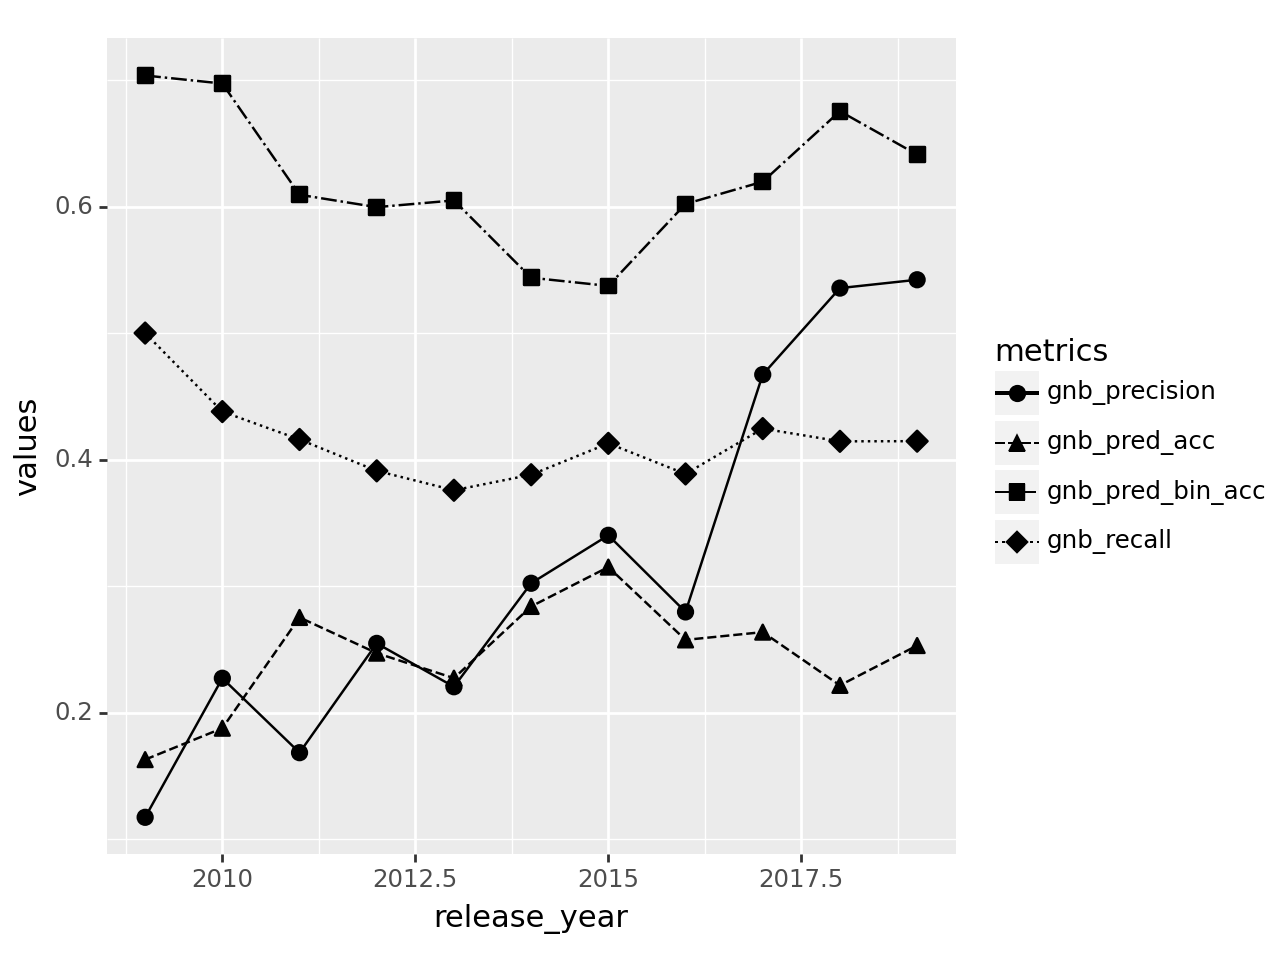

In [31]:
gnb_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index()
gnb_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['gnb_pred_bin_acc'].mean().reset_index()
gnb_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_recall'})
gnb_precision_tbyyear = data_predict[data_predict['gnb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['gnb_pred_acc'].mean().reset_index().rename(columns={'gnb_pred_acc':'gnb_precision'})
gnb_metrics = pd.concat([gnb_mean_acc_tbyyear, gnb_mean_bin_acc_tbyyear['gnb_pred_bin_acc'], gnb_recall_tbyyear['gnb_recall'], gnb_precision_tbyyear['gnb_precision']], axis=1)
display(gnb_metrics)
gnb_metrics = gnb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
gnb_metrics_plot = ggplot(gnb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(gnb_metrics_plot)

gnb_metrics.to_pickle('pickles/gnb_metrics_gtzan.pkl')

## K-Nearest Neighbors

,release_year,treatment_year,knn_pred_acc,knn_pred_bin_acc,knn_recall,knn_precision
0,2009,1,0.160524,0.087633,0.611111,0.085492
1,2010,1,0.200970,0.115731,0.693431,0.192698
2,2011,1,0.264346,0.109607,0.628319,0.142285
3,2012,1,0.220050,0.107268,0.520295,0.186016
4,2013,1,0.225768,0.115839,0.570064,0.190223
5,2014,1,0.284461,0.139645,0.541045,0.271536
6,2015,1,0.289047,0.121925,0.565359,0.266427
7,2016,1,0.237427,0.105416,0.492344,0.214469
8,2017,0,0.272933,0.155445,0.588584,0.395679
9,2018,0,0.248575,0.171985,0.589659,0.450609


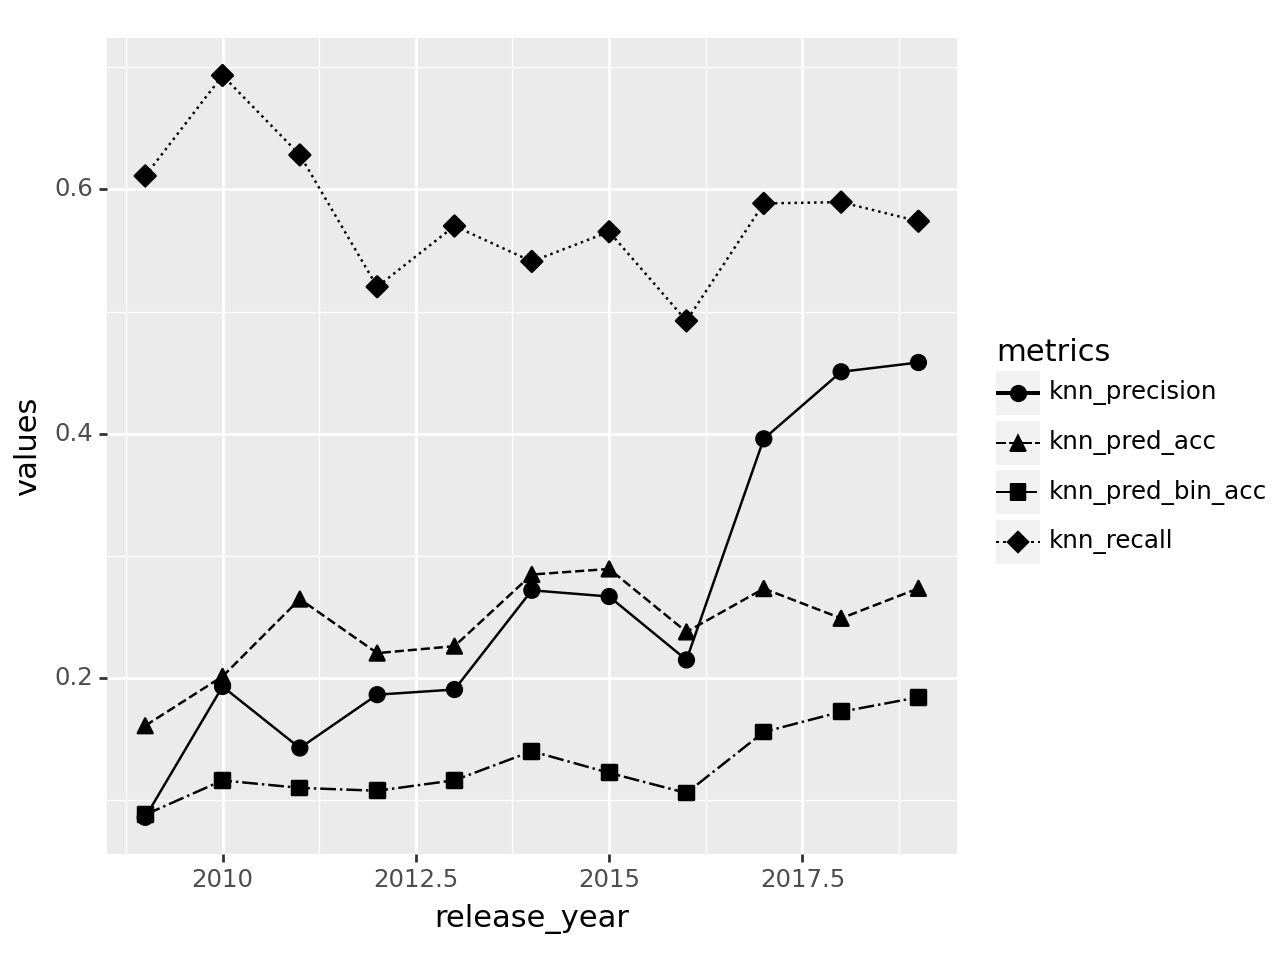

In [32]:
knn_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index()
knn_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['knn_pred_bin_acc'].mean().reset_index()
knn_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_recall'})
knn_precision_tbyyear = data_predict[data_predict['knn_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['knn_pred_acc'].mean().reset_index().rename(columns={'knn_pred_acc':'knn_precision'})
knn_metrics = pd.concat([knn_mean_acc_tbyyear, knn_mean_bin_acc_tbyyear['knn_pred_bin_acc'], knn_recall_tbyyear['knn_recall'], knn_precision_tbyyear['knn_precision']], axis=1)
display(knn_metrics)
knn_metrics = knn_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
knn_metrics_plot = ggplot(knn_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(knn_metrics_plot)

knn_metrics.to_pickle('pickles/knn_metrics_gtzan.pkl')

## Random Forest

,release_year,treatment_year,rf_pred_acc,rf_pred_bin_acc,rf_recall,rf_precision
0,2009,1,0.364455,0.276822,0.425926,0.103604
1,2010,1,0.404712,0.300762,0.525547,0.247423
2,2011,1,0.448743,0.270148,0.407080,0.167273
3,2012,1,0.421053,0.281203,0.328413,0.191398
4,2013,1,0.410559,0.289992,0.372611,0.201031
5,2014,1,0.451315,0.268271,0.333333,0.290672
6,2015,1,0.444505,0.261163,0.377996,0.294567
7,2016,1,0.398291,0.257415,0.336867,0.238731
8,2017,0,0.406055,0.279169,0.421142,0.448447
9,2018,0,0.393697,0.306624,0.408141,0.500337


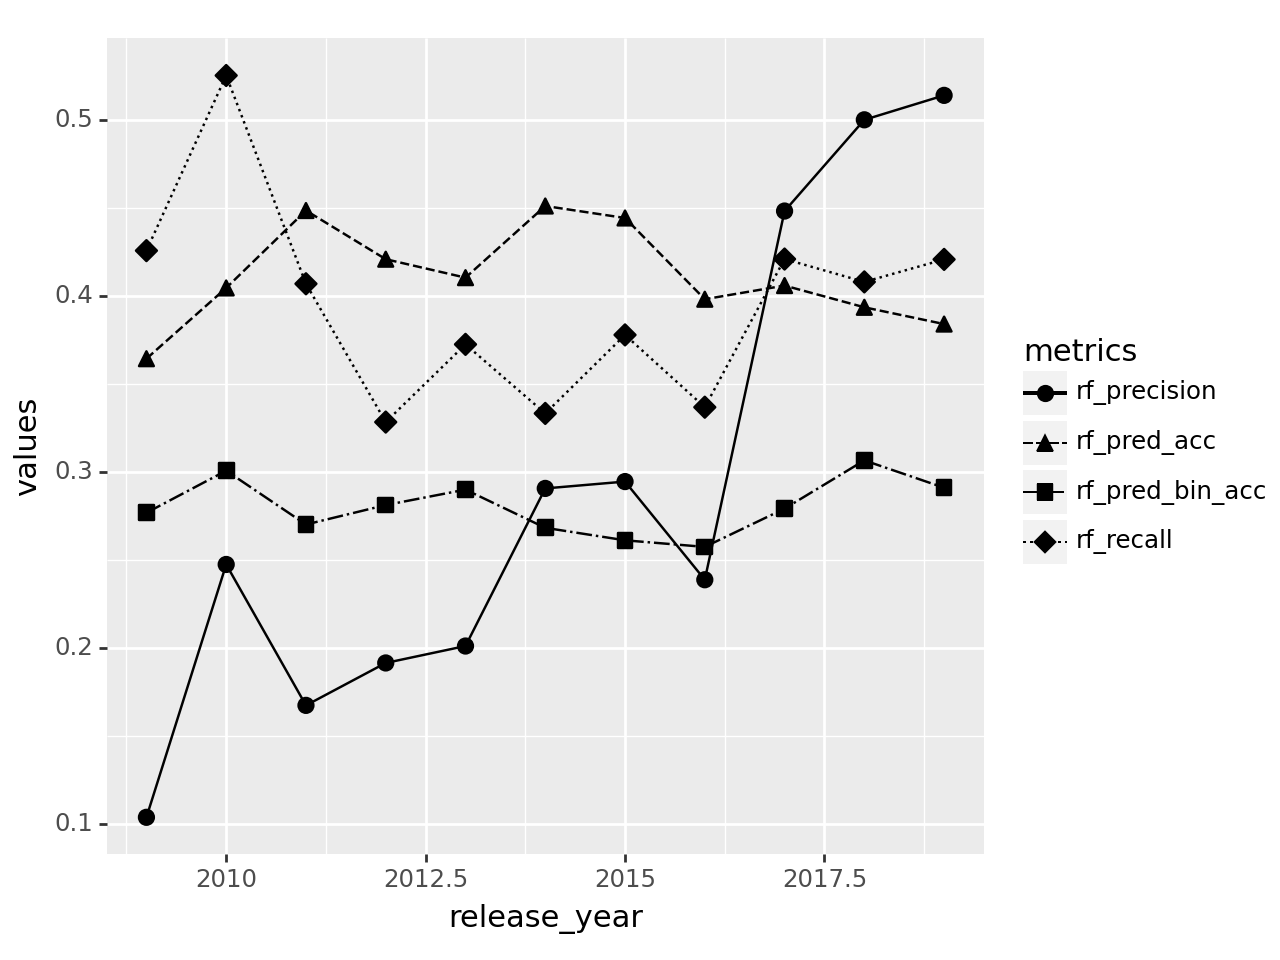

In [33]:
rf_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index()
rf_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['rf_pred_bin_acc'].mean().reset_index()
rf_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_recall'})
rf_precision_tbyyear = data_predict[data_predict['rf_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['rf_pred_acc'].mean().reset_index().rename(columns={'rf_pred_acc':'rf_precision'})
rf_metrics = pd.concat([rf_mean_acc_tbyyear, rf_mean_bin_acc_tbyyear['rf_pred_bin_acc'], rf_recall_tbyyear['rf_recall'], rf_precision_tbyyear['rf_precision']], axis=1)
display(rf_metrics)
rf_metrics = rf_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')
rf_metrics_plot = ggplot(rf_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(rf_metrics_plot)

rf_metrics.to_pickle('pickles/rf_metrics_gtzan.pkl')

## XGBoost

,release_year,treatment_year,xgb_pred_acc,xgb_pred_bin_acc,xgb_recall,xgb_precision
0,2009,1,0.0,0.0,0.0,NaN
1,2010,1,0.0,0.0,0.0,NaN
2,2011,1,0.0,0.0,0.0,NaN
3,2012,1,0.0,0.0,0.0,NaN
4,2013,1,0.0,0.0,0.0,NaN
5,2014,1,0.0,0.0,0.0,NaN
6,2015,1,0.0,0.0,0.0,NaN
7,2016,1,0.0,0.0,0.0,NaN
8,2017,0,0.0,0.0,0.0,NaN
9,2018,0,0.0,0.0,0.0,NaN


/home/mhelias004/Downloads/ls/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 11 rows containing missing values.
/home/mhelias004/Downloads/ls/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 11 rows containing missing values.


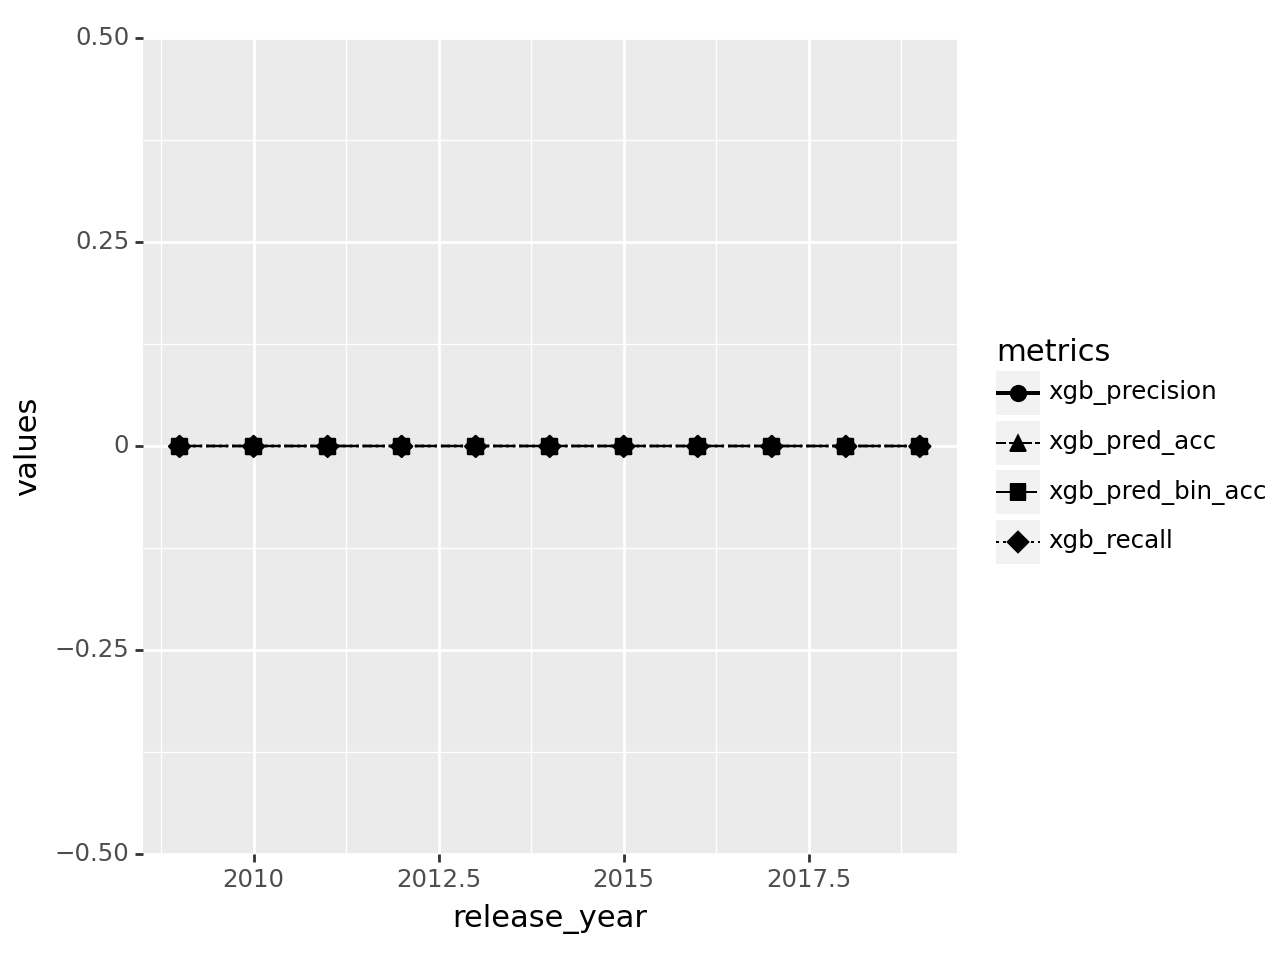

In [34]:
# xgb_mean_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index()
# xgb_mean_bin_acc_tbyyear = data_predict.groupby(['release_year', 'treatment_year'])['xgb_pred_bin_acc'].mean().reset_index()
# xgb_recall_tbyyear = data_predict[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_recall'})
# xgb_precision_tbyyear = data_predict[data_predict['xgb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_precision'})
# xgb_metrics = pd.concat([xgb_mean_acc_tbyyear, xgb_mean_bin_acc_tbyyear['xgb_pred_bin_acc'], xgb_recall_tbyyear['xgb_recall'], xgb_precision_tbyyear['xgb_precision']], axis=1)
# display(xgb_metrics)
# xgb_metrics = xgb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')

xgb_mean_acc_tbyyear     = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index()
xgb_mean_bin_acc_tbyyear = data_predict.copy().groupby(['release_year', 'treatment_year'])['xgb_pred_bin_acc'].mean().reset_index()
xgb_recall_tbyyear       = data_predict.copy()[data_predict['tag'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_recall'})
xgb_precision_tbyyear    = data_predict.copy()[data_predict['xgb_pred'] == 'hiphop'].groupby(['release_year', 'treatment_year'])['xgb_pred_acc'].mean().reset_index().rename(columns={'xgb_pred_acc':'xgb_precision'})
xgb_metrics = pd.concat([xgb_mean_acc_tbyyear, xgb_mean_bin_acc_tbyyear['xgb_pred_bin_acc'], xgb_recall_tbyyear['xgb_recall'], xgb_precision_tbyyear['xgb_precision']], axis=1)
display(xgb_metrics)
xgb_metrics = xgb_metrics.melt(id_vars=['release_year', 'treatment_year'], var_name='metrics', value_name='values')

xgb_metrics_plot = ggplot(xgb_metrics, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(xgb_metrics_plot)

xgb_metrics.to_pickle('pickles/xgb_metrics_gtzan.pkl')

## Average

,release_year,treatment_year,metrics,values
0,2009,0,classifiers_pred_acc,0.153358
1,2010,0,classifiers_pred_acc,0.180527
2,2011,0,classifiers_pred_acc,0.235654
3,2012,0,classifiers_pred_acc,0.208396
4,2013,0,classifiers_pred_acc,0.200453
5,2014,0,classifiers_pred_acc,0.236170
6,2015,0,classifiers_pred_acc,0.244214
7,2016,0,classifiers_pred_acc,0.208777
8,2017,1,classifiers_pred_acc,0.217736
9,2018,1,classifiers_pred_acc,0.196799


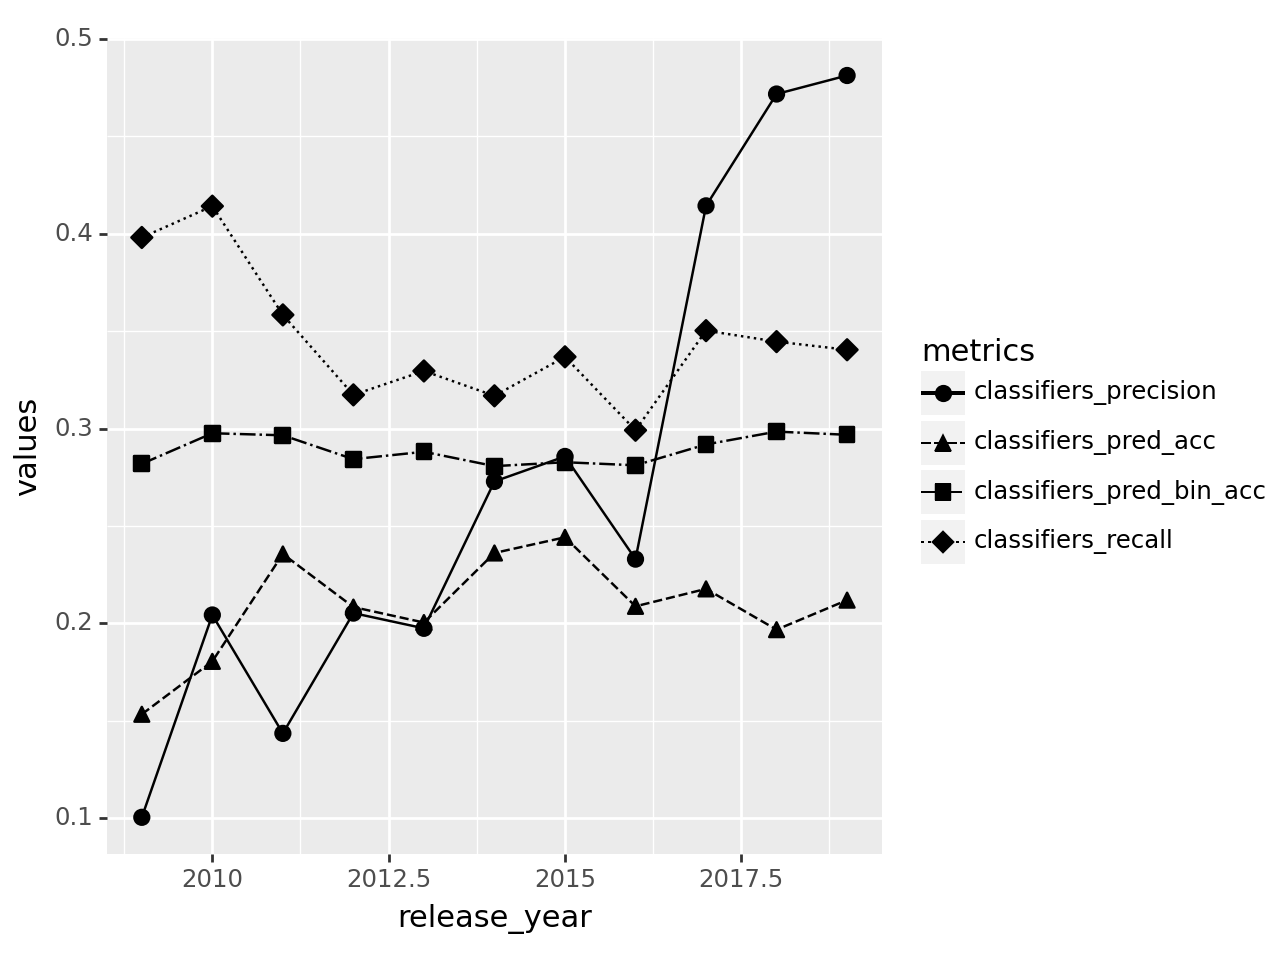

In [27]:
average = pd.concat([gnb_metrics['values'], knn_metrics['values'], rf_metrics['values'], xgb_metrics['values']], names = ['values', 'values_1', 'values_2', 'values_3'], axis=1)
average = average.mean(axis=1)
average = pd.concat([gnb_metrics['release_year'], gnb_metrics['treatment_year'], gnb_metrics['metrics'], average],axis=1)
average['metrics'] = average['metrics'].str.replace('gnb_', 'classifiers_')
average = average.rename(columns={0: "values"})
average.to_pickle('pickles/classifiers_metrics_gtzan.pkl')
display(average)

average_plot = ggplot(average, aes(x='release_year', y='values')) + geom_point(aes(shape='metrics'), size=2.5) + geom_line(aes(linetype='metrics'))
print(average_plot)